# S4. Identify CCC patterns from spatial transcriptomics

This tutorial illustrates how LIANA and Tensor-cell2cell can be used to explore cell-cell communication in distinct regions of a tissue using spatial transcriptomics. Here each region of the tissue is treated as a separate context.

## Initial Setups

### Enabling GPU use

First, if you are using a NVIDIA GPU with CUDA cores, set `use_gpu=True` and enable PyTorch with the following code block. Otherwise, set `use_gpu=False` or skip this part

In [1]:
use_gpu = True

if use_gpu:
    import tensorly as tl
    tl.set_backend('pytorch')

### Libraries
Then, import all the packages we will use in this tutorial:

In [2]:
import cell2cell as c2c
import decoupler as dc
import liana as li

import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import squareform

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Directories

Afterwards, specify the data and output directories:

In [4]:
output_folder = '../../data/spatial/'
c2c.io.directories.create_directory(output_folder)

../../data/spatial/ was created successfully.


## Load data

Similar to [the tutorial of using LIANA and MISTy](https://liana-py.readthedocs.io/en/latest/notebooks/misty.html), we will use an ischemic 10X Visium spatial slide from [Kuppe et al., 2022](https://www.nature.com/articles/s41586-022-05060-x). It is a tissue sample obtained from a patient with myocardial infarction, specifically focusing on the ischemic zone of the heart tissue.

The slide provides spatially-resolved information about the cellular composition and gene expression patterns within the tissue.

In [5]:
adata = sc.read("kuppe_heart19.h5ad", backup_url='https://figshare.com/ndownloader/files/41501073?private_link=4744950f8768d5c8f68c')

  0%|          | 0.00/44.4M [00:00<?, ?B/s]

In [6]:
adata

AnnData object with n_obs × n_vars = 4113 × 17703
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'rps', 'mrp', 'rpl', 'duplicated'
    uns: 'spatial'
    obsm: 'compositions', 'mt', 'spatial'

## Process data

Normalize data

In [7]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Visualize spot clusters or niches. These niches were defined by clustering spots from their cellular composition deconvoluted by using cell2location ([Kuppe et al., 2022](https://www.nature.com/articles/s41586-022-05060-x)).

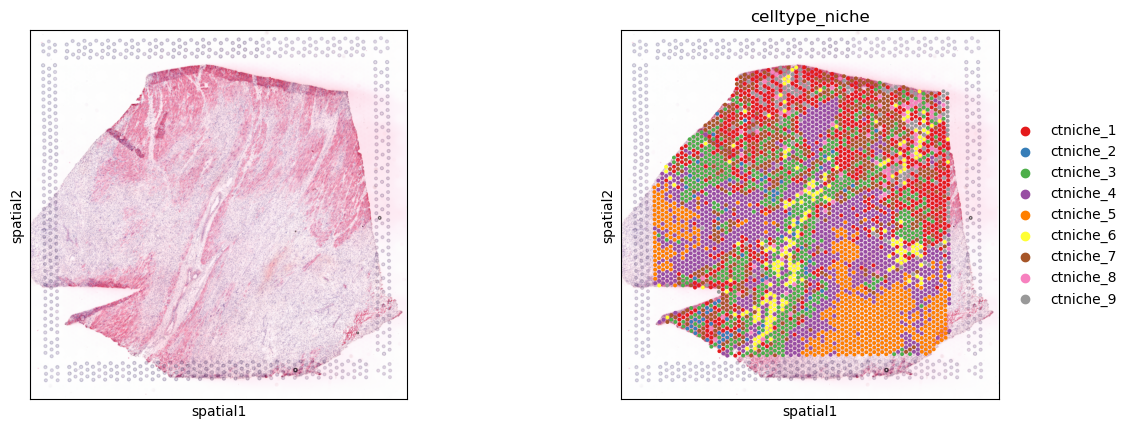

In [8]:
sq.pl.spatial_scatter(adata, color=[None, 'celltype_niche'], size=1.3, palette='Set1')

Cellular composition obtained from cell2location

In [9]:
# Rename to more informative names
full_names = {'Adipo': 'Adipocytes',
              'CM': 'Cardiomyocytes',
              'Endo': 'Endothelial',
              'Fib': 'Fibroblasts',
              'PC': 'Pericytes',
              'prolif': 'Proliferating',
              'vSMCs': 'Vascular_SMCs',
              }
# but only for the ones that are in the data
adata.obsm['compositions'].columns = [full_names.get(c, c) for c in adata.obsm['compositions'].columns]

In [10]:
comps = li.ut.obsm_to_adata(adata, 'compositions')

In [11]:
comps.var

Empty DataFrame
Columns: []
Index: [Adipocytes, Cardiomyocytes, Endothelial, Fibroblasts, Lymphoid, Mast, Myeloid, Neuronal, Pericytes, Proliferating, Vascular_SMCs]

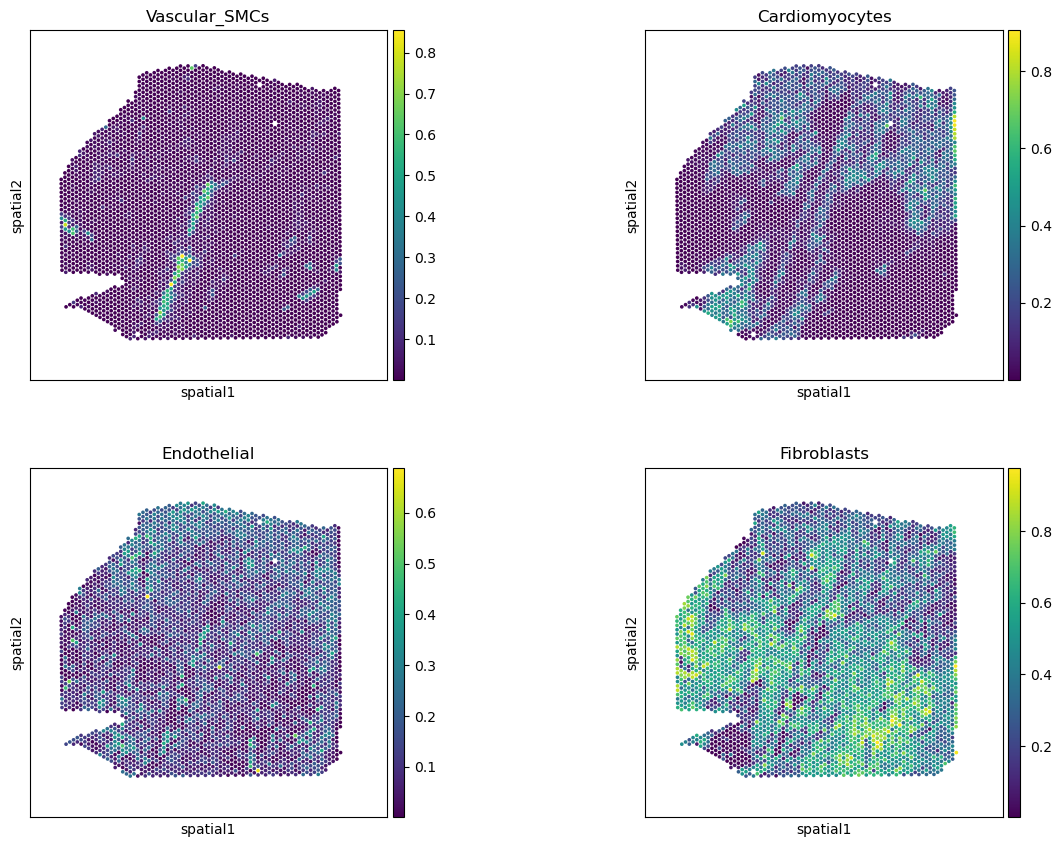

In [12]:
# check key cell types
sq.pl.spatial_scatter(comps,
                      color=['Vascular_SMCs','Cardiomyocytes',
                             'Endothelial', 'Fibroblasts'],
                      size=1.3, ncols=2, img_alpha=0
                      )

In [13]:
adata_og = adata.copy()

## Defining spatial contexts in the tissue

For defining spatial contexts within a tissue using spatial transcriptomics we simply divide the tissue in different regions through a square grid of a specific number of bins in each of the axes. 

In this case, we divide our tissue into a 4x4 grid. A new column will be create in the `adata` object, specifically `adata.obs['grid_cell']`, to assign each spot or cell a grid window.

In [14]:
num_bins = 4

In [15]:
c2c.spatial.create_spatial_grid(adata, num_bins=num_bins)

... storing 'grid_cell' as categorical


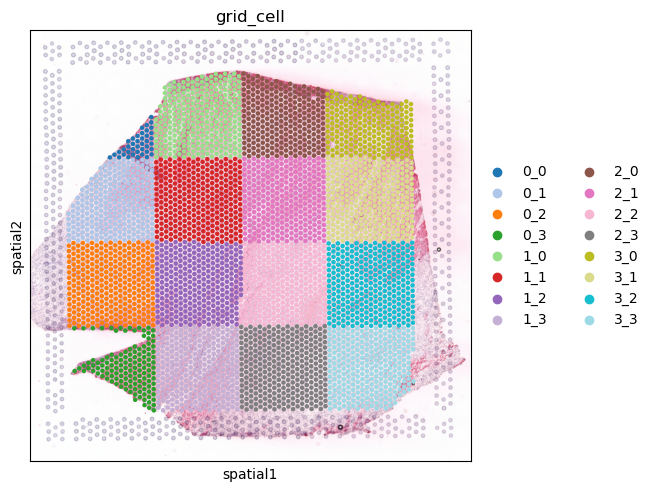

In [16]:
sq.pl.spatial_scatter(adata, color='grid_cell', size=1.3, palette='tab20')

Here, cells or spots in one grid window do not get to interact with those that are within other grid windows, ignoring that cells in the interfaces between grid windows could also interact. For accounting for those cases, more complex approaches could be employed, as for example a sliding window strategy for defining contexts. In that case, spatial contexts will present some overlap in the cells or spots that are within them.

For simplicity we only tried the grid approach, which could be replaced by the sliding windows method, but it would also require to account for the overlap between spatial contexts. If you are interested in trying out this approach, see `cell2cell.spatial.neighborhood.create_sliding_windows()` and `cell2cell.spatial.neighborhood.add_sliding_window_info_to_adata()`. 

## Deciphering cell-cell communication

Here we run LIANA to compute interactions between spots or cells aggregated by their corresponding cluster/niche annotations. Interactions are computed for each spatial context (grid window) by considering only cells annotated with such spatial context in the `grid_cell` column in the `adata.obs` DataFrame.

In this case we use the CellPhoneDB list of ligand-receptor interactions, and the CellPhoneDB method to infer CCC.

In [17]:
cell_group = 'celltype_niche'

In [18]:
lr_pairs = li.resource.select_resource('cellchatdb')

In [19]:
li.mt.cellphonedb.by_sample(adata, resource=lr_pairs, groupby=cell_group, sample_key='grid_cell',
                            expr_prop=0.1, use_raw=False, verbose=True)

Now running: 3_3: 100%|█████████████████████████| 16/16 [01:16<00:00,  4.78s/it]


The results are located here:

In [20]:
spatial_liana = adata.uns['liana_res']

In [21]:
spatial_liana

grid_cell  ligand ligand_complex  ligand_means  ligand_props receptor  \
0            0_0     FN1            FN1      4.556507      1.000000    ITGAV   
1            0_0     FN1            FN1      4.556507      1.000000    ITGAV   
2            0_0     FN1            FN1      4.342961      1.000000    ITGAV   
3            0_0     FN1            FN1      4.312120      1.000000    ITGAV   
4            0_0     FN1            FN1      4.342961      1.000000    ITGAV   
...          ...     ...            ...           ...           ...      ...   
195553       3_3    WNT3           WNT3      0.064199      0.200000     LRP6   
195554       3_3    WNT3           WNT3      0.064199      0.200000     LRP6   
195555       3_3    WNT3           WNT3      0.064199      0.200000     LRP6   
195556       3_3    POMC           POMC      0.052017      0.104478     MC1R   
195557       3_3  SEMA3A         SEMA3A      0.064199      0.200000   PLXNA4   

       receptor_complex  receptor_means  receptor_props     source     target  \
0           ITGAV_ITGB1        2.021336            1.00  ctniche_1  ctniche_3   
1           ITGAV_ITGB1        1.928708            1.00  ctniche_1  ctniche_7   
2           ITGAV_ITGB1        2.021336            1.00  ctniche_3  ctniche_3   
3           ITGAV_ITGB1        2.021336            1.00  ctniche_7  ctniche_3   
4           ITGAV_ITGB1        1.928708            1.00  ctniche_3  ctniche_7   
...                 ...             ...             ...        ...        ...   
195553        FZD6_LRP6        0.081630            0.20  ctniche_3  ctniche_3   
195554        FZD1_LRP6        0.081630            0.20  ctniche_3  ctniche_3   
195555        FZD8_LRP6        0.081630            0.20  ctniche_3  ctniche_3   
195556             MC1R        0.078427            0.11  ctniche_4  ctniche_5   
195557      NRP1_PLXNA4        0.064199            0.20  ctniche_3  ctniche_3   

        lr_means  cellphone_pvals  
0       3.288921            0.083  
1       3.242608            0.155  
2       3.182149            0.299  
3       3.166728            0.374  
4       3.135835            0.499  
...          ...              ...  
195553  0.072915            0.538  
195554  0.072915            0.538  
195555  0.072915            0.538  
195556  0.065222            0.644  
195557  0.064199            0.116  

[195558 rows x 13 columns]

### Using LIANA results to build a 4D-communication tensor, with grid windows as the contexts in the 4th dimension.

In [22]:
tensor = li.multi.to_tensor_c2c(liana_res=spatial_liana, # LIANA's dataframe containing results
                                sample_key='grid_cell', # Column name of the samples
                                source_key='source', # Column name of the sender cells
                                target_key='target', # Column name of the receiver cells
                                ligand_key='ligand_complex', # Column name of the ligands
                                receptor_key='receptor_complex', # Column name of the receptors
                                score_key='lr_means', # Column name of the communication scores to use
                                inverse_fun=None, # Transformation function
                                how='outer', # What to include across all samples
                                outer_fraction=1/4., # Fraction of samples as threshold to include cells and LR pairs.
                               )

100%|███████████████████████████████████████████| 16/16 [00:19<00:00,  1.21s/it]


Metadata for coloring the elements in the tensor.

Here we do not assign major groups, each element is colored separately.

In [23]:
dimensions_dict = [None, None, None, None]
meta_tensor = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                  metadata_dicts=dimensions_dict,
                                                  fill_with_order_elements=True
                                                 )

Tensor properties

In [24]:
tensor.shape

torch.Size([16, 700, 9, 9])

In [25]:
tensor.excluded_value_fraction()

0.7867879122495651

In [26]:
tensor.sparsity_fraction()

0.0

### Run Tensor-cell2cell pipeline

For simplicity, we factorize the tensor into 8 factors or CCC patterns instead of using the elbow analysis to determine the number of factors.

Running Tensor Factorization
Generating Outputs
Loadings of the tensor factorization were successfully saved into ../../data/spatial//Loadings.xlsx


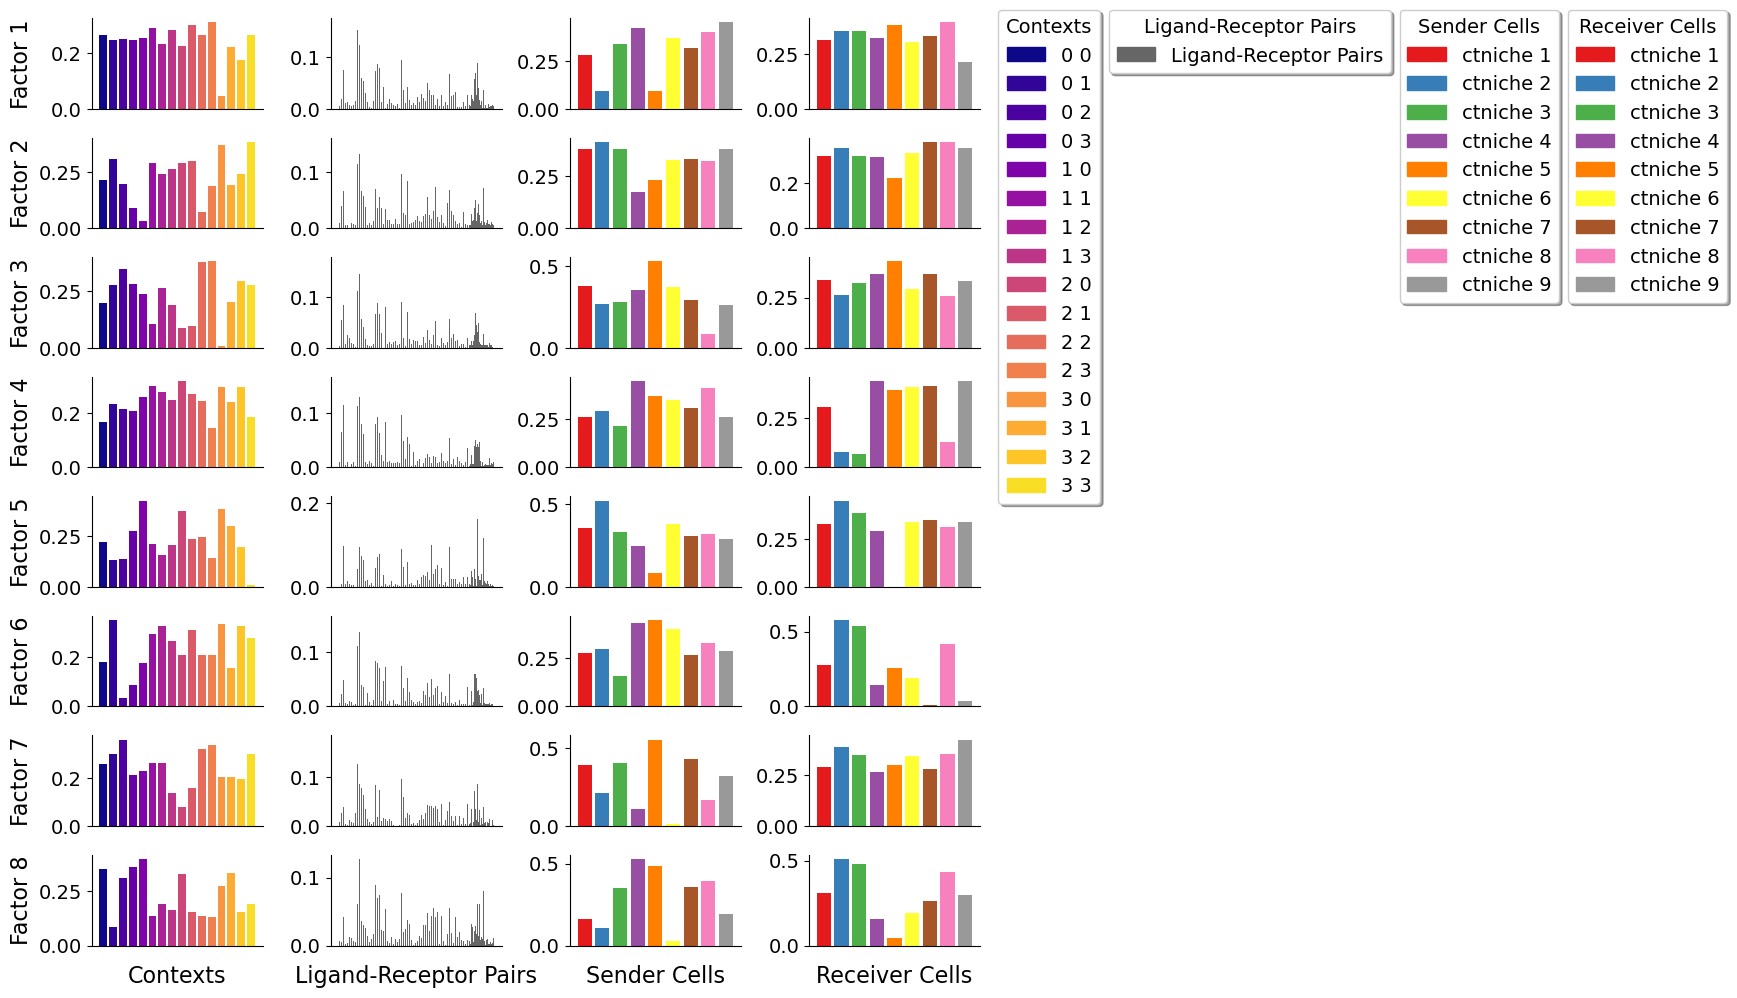

In [27]:
c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                           meta_tensor,
                                           rank=8, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis
                                           tf_optimization='regular', # To define how robust we want the analysis to be.
                                           random_state=0, # Random seed for reproducibility
                                           device='cuda', # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                           cmaps=['plasma', 'Dark2_r', 'Set1', 'Set1'],
                                           output_folder=output_folder, # Whether to save the figures in files. If so, a folder pathname must be passed
                                          )

### Visualize CCC patterns in space

Each factor or CCC pattern contains loadings for the context dimension. These loadings could be mapped for each spot or cell depending on what spatial context (grid window) they belong to. Thus, we can visualize the importance of each context in each of the factors, and see how the CCC patterns behave in space.

This behavior in space is useful to understand what set of LR pairs are used by determinant sender-receiver spot pairs in each region of the tissue. Regions with higher scores, indicate that LR pairs of that factor are used more there by the senders and receivers with high loadings.

In [28]:
# Generate columns in the adata.obs dataframe with the loading values of each factor
factor_names = list(tensor.factors['Contexts'].columns)
for f in factor_names:
    adata.obs[f] = adata.obs['grid_cell'].apply(lambda x: float(tensor.factors['Contexts'][f].to_dict()[x]))
    adata.obs[f] = pd.to_numeric(adata.obs[f])

Text(0.5, 0.98, '4x4 Spatial Grid')

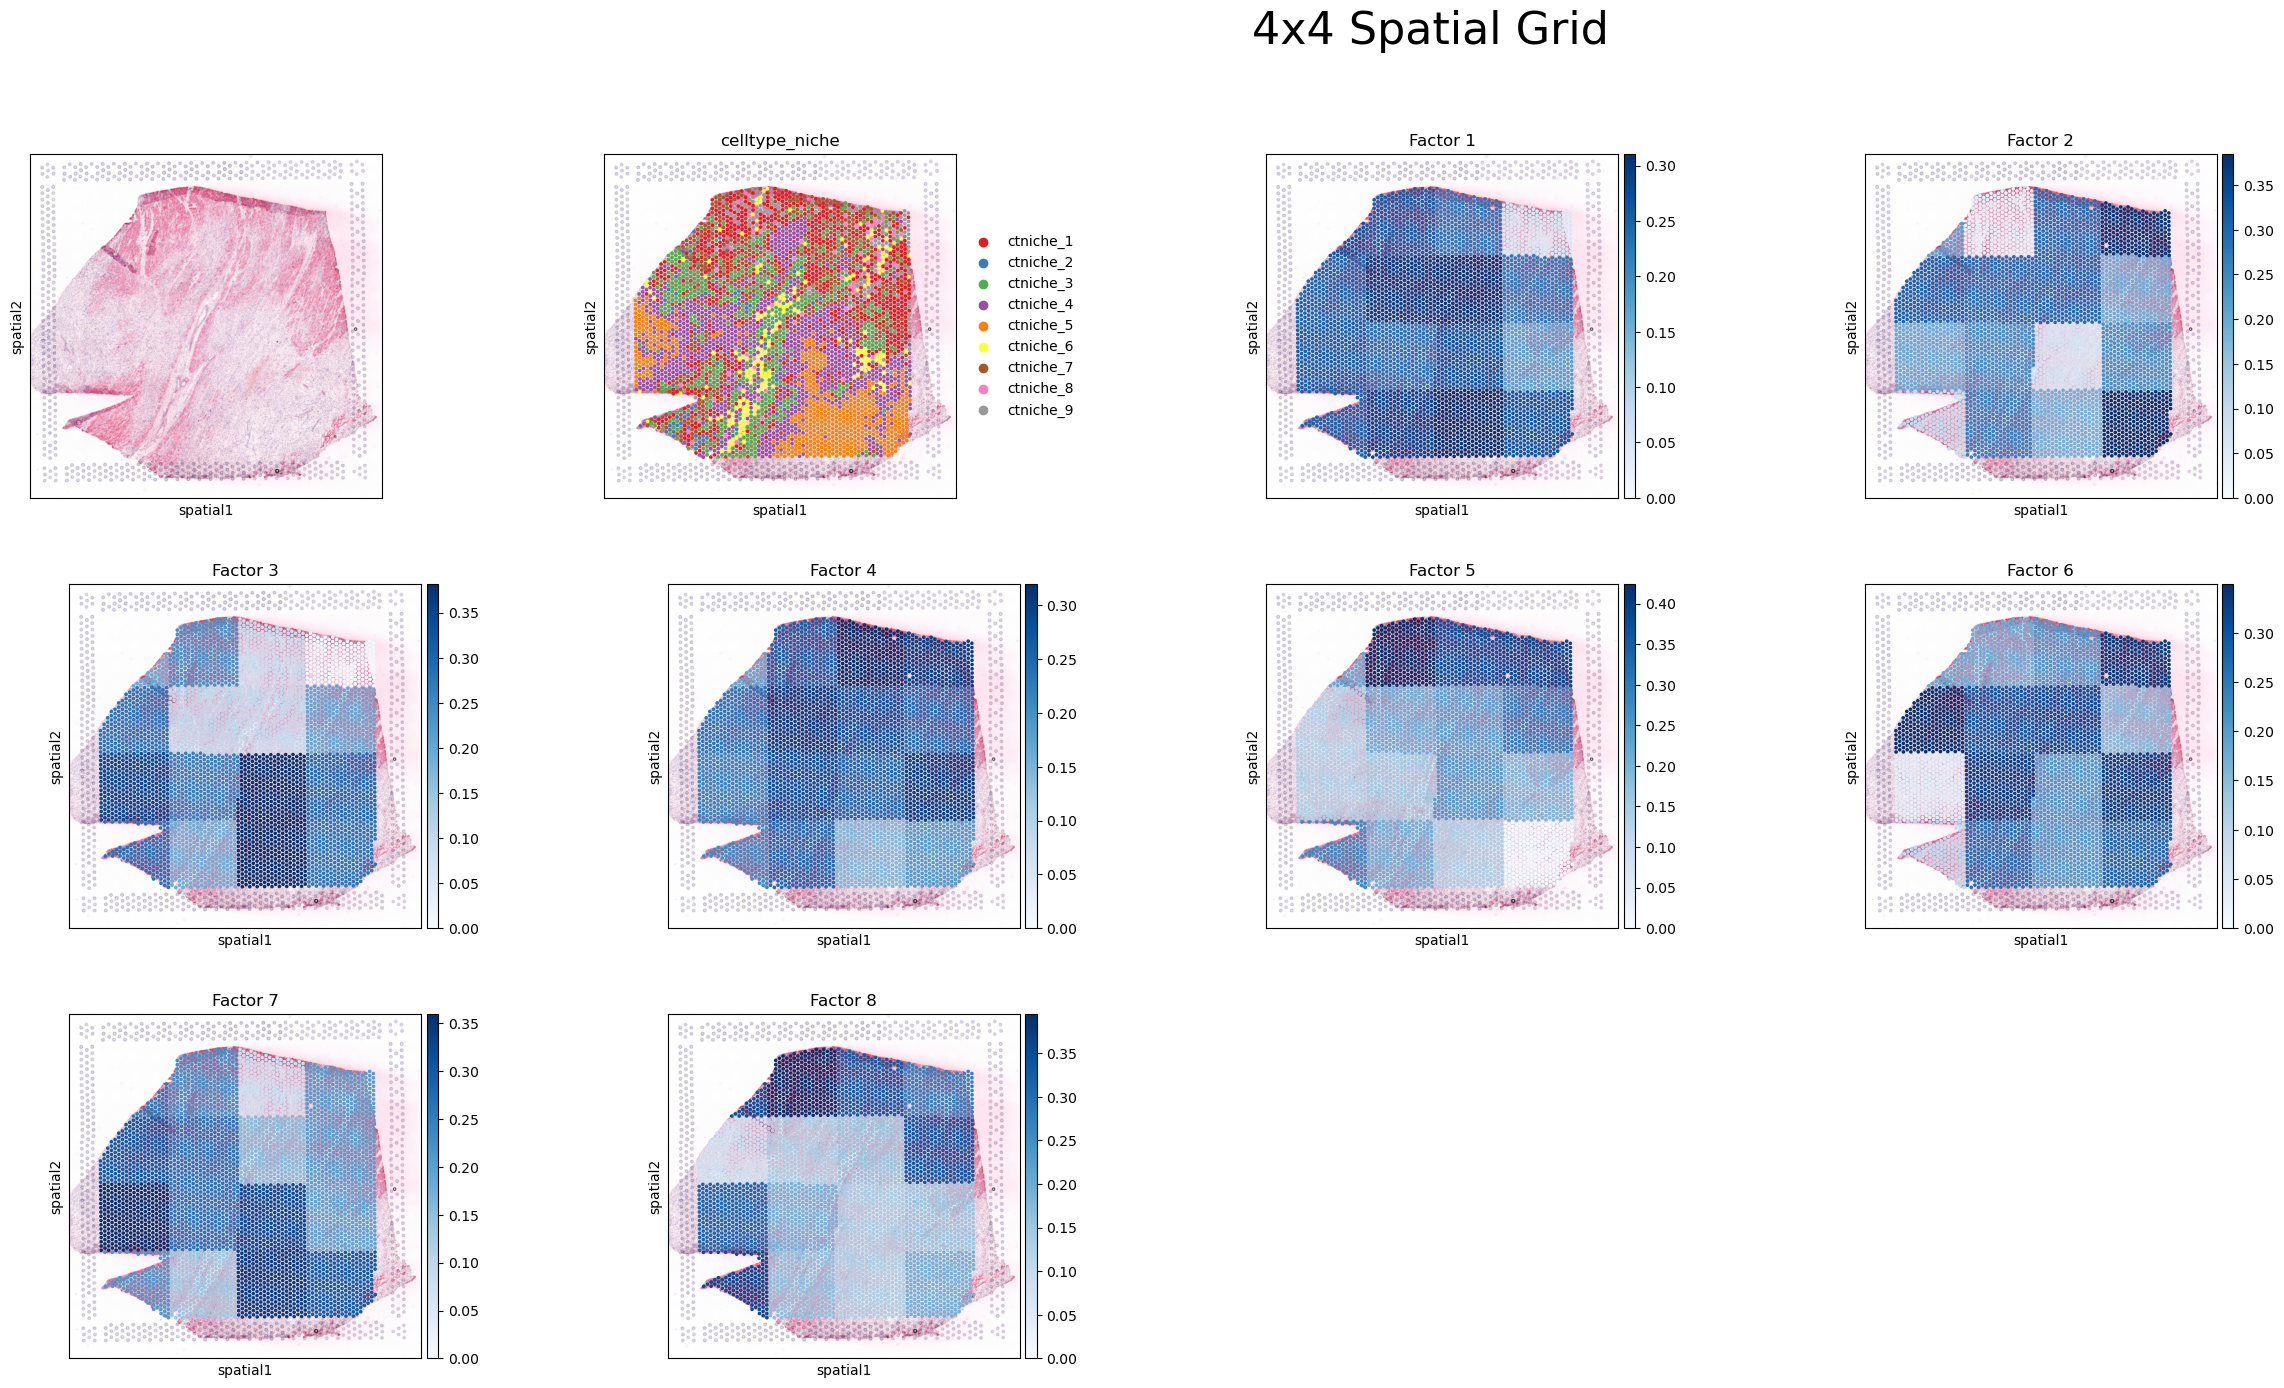

In [29]:
# These columns are used for coloring the tissue regions to associate them with each factor
sq.pl.spatial_scatter(adata, color=[None, 'celltype_niche']+factor_names, size=1.3, cmap='Blues', vmin=0.)
plt.suptitle(f'{num_bins}x{num_bins} Spatial Grid', fontsize=32, ha='left')

For example, we can take Factor 5 here, and see that regions in the top area of the tissue, and the bottom left corner are associated with the CCC pattern. Here, main interacting spots are niches 1 and 2 (mainly composed of cardiomyocytes and endothelial cells), coinciding with the areas where they are mainly located.

Then, using the LR pair loadings, we can also identify LR interactions that are key in each factor, and link this with the spatial region with higher scores in the same factor.

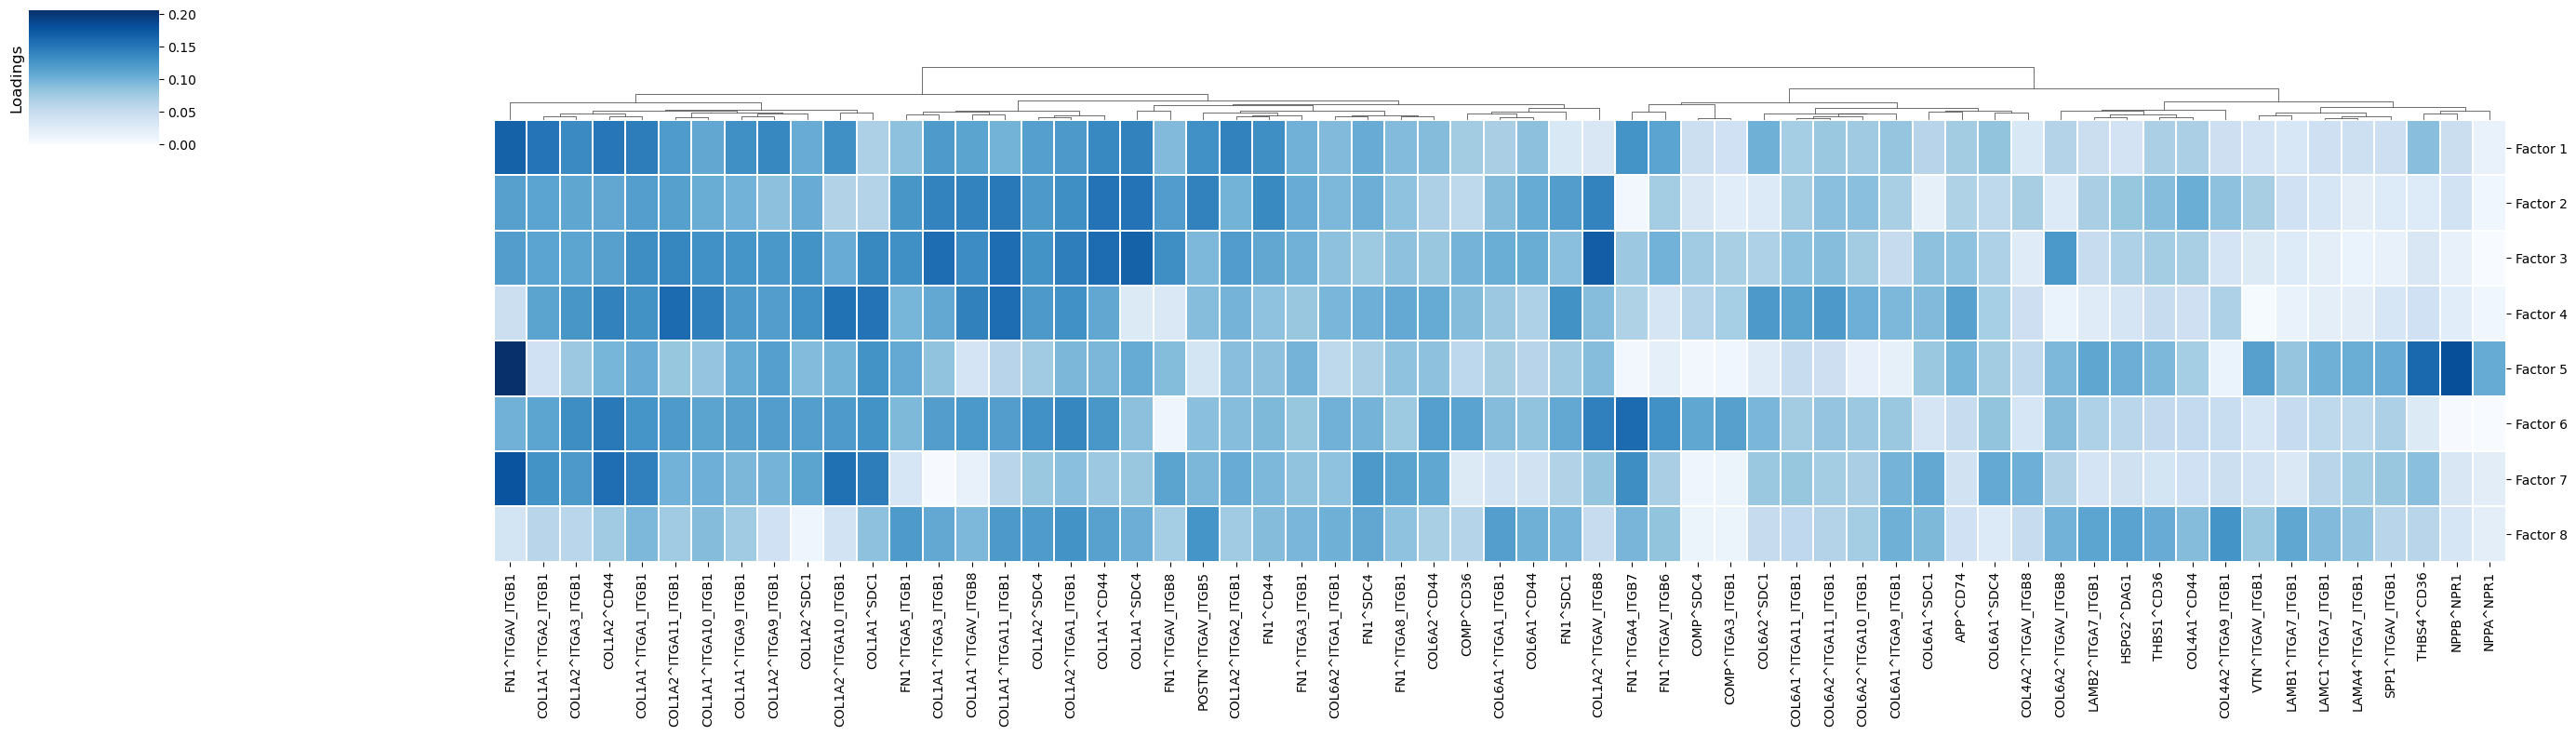

In [30]:
_ = c2c.plotting.loading_clustermap(loadings=tensor.factors['Ligand-Receptor Pairs'],
                                    loading_threshold=0.1,
                                    use_zscore=False,
                                    figsize=(28, 8),
                                    filename=None,
                                    row_cluster=False
                                   )

In factor 5, where interactions of niches 1 and 2 are associated with this CCC pattern, LR interactions such as NPPB^NPR1, THBS4^CD36, and FN1^ITGAV&ITGB1 are important.

Following the same idea, other downstream analyses could be performed (e.g., Pathway enrichment analysis, PROGENy analysis, among others - see [this notebook](./05-Downstream-Visualizations.ipynb)), and use the resulting scores to associate them with important tissue regions per factor.

Finally, for comparing tissues from multiple patients, a 4D tensor could be built for the same tissue region across patients. So the 4th dimension would be a tissue region aligned and present across patients.

## Different grid sizes

We can also explore changing the number of bins in the grid to see the impact on the analysis. With this we can focus on shorter- or longer-ranges of interactions.

In [31]:
def run_pipeline_per_bins(adata, lr_pairs, cell_group, bin_list, output_folder=None):
    results = {}
    for num_bins in bin_list:
        if output_folder is not None:
            output_folder = output_folder + '/NumBins-{}/'.format(num_bins)
            c2c.io.directories.create_directory(output_folder)
        
        tmp_result = {}
        adata_ = adata.copy()
        c2c.spatial.create_spatial_grid(adata_, num_bins=num_bins)

        li.mt.cellphonedb.by_sample(adata_, resource=lr_pairs, groupby=cell_group, sample_key='grid_cell',
                                    expr_prop=0.1, use_raw=False, verbose=True)

        spatial_liana = adata_.uns['liana_res']
        tensor = li.multi.to_tensor_c2c(liana_res=spatial_liana, # LIANA's dataframe containing results
                                        sample_key='grid_cell', # Column name of the samples
                                        source_key='source', # Column name of the sender cells
                                        target_key='target', # Column name of the receiver cells
                                        ligand_key='ligand_complex', # Column name of the ligands
                                        receptor_key='receptor_complex', # Column name of the receptors
                                        score_key='lr_means', # Column name of the communication scores to use
                                        inverse_fun=None, # Transformation function
                                        how='outer', # What to include across all samples
                                        outer_fraction=1/4., # Fraction of samples as threshold to include cells and LR pairs.
                                       )

        dimensions_dict = [None, None, None, None]
        meta_tensor = c2c.tensor.generate_tensor_metadata(interaction_tensor=tensor,
                                                          metadata_dicts=dimensions_dict,
                                                          fill_with_order_elements=True
                                                         )

        c2c.analysis.run_tensor_cell2cell_pipeline(tensor,
                                                   meta_tensor,
                                                   rank=8, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis
                                                   tf_optimization='regular', # To define how robust we want the analysis to be.
                                                   random_state=0, # Random seed for reproducibility
                                                   device='cuda', # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
                                                   cmaps=['plasma', 'Dark2_r', 'Set1', 'Set1'],
                                                   output_folder=output_folder, # Whether to save the figures in files. If so, a folder pathname must be passed
                                                  )

        # Generate columns in the adata_.obs dataframe with the loading values of each factor
        factor_names = list(tensor.factors['Contexts'].columns)
        for f in factor_names:
            adata_.obs[f] = adata_.obs['grid_cell'].apply(lambda x: float(tensor.factors['Contexts'][f].to_dict()[x]))
            adata_.obs[f] = pd.to_numeric(adata_.obs[f])

        tmp_result['tensor'] = tensor
        tmp_result['tensor_meta'] = meta_tensor
        tmp_result['adata'] = adata_
        results[num_bins] = tmp_result
    return results

../../data/spatial//NumBins-2/ was created successfully.


Converting `grid_cell` to categorical!
100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]


Running Tensor Factorization
Generating Outputs
Loadings of the tensor factorization were successfully saved into ../../data/spatial//NumBins-2//Loadings.xlsx


Converting `grid_cell` to categorical!


../../data/spatial//NumBins-2//NumBins-3/ was created successfully.


100%|█████████████████████████████████████████████| 9/9 [00:12<00:00,  1.40s/it]


Running Tensor Factorization
Generating Outputs
Loadings of the tensor factorization were successfully saved into ../../data/spatial//NumBins-2//NumBins-3//Loadings.xlsx


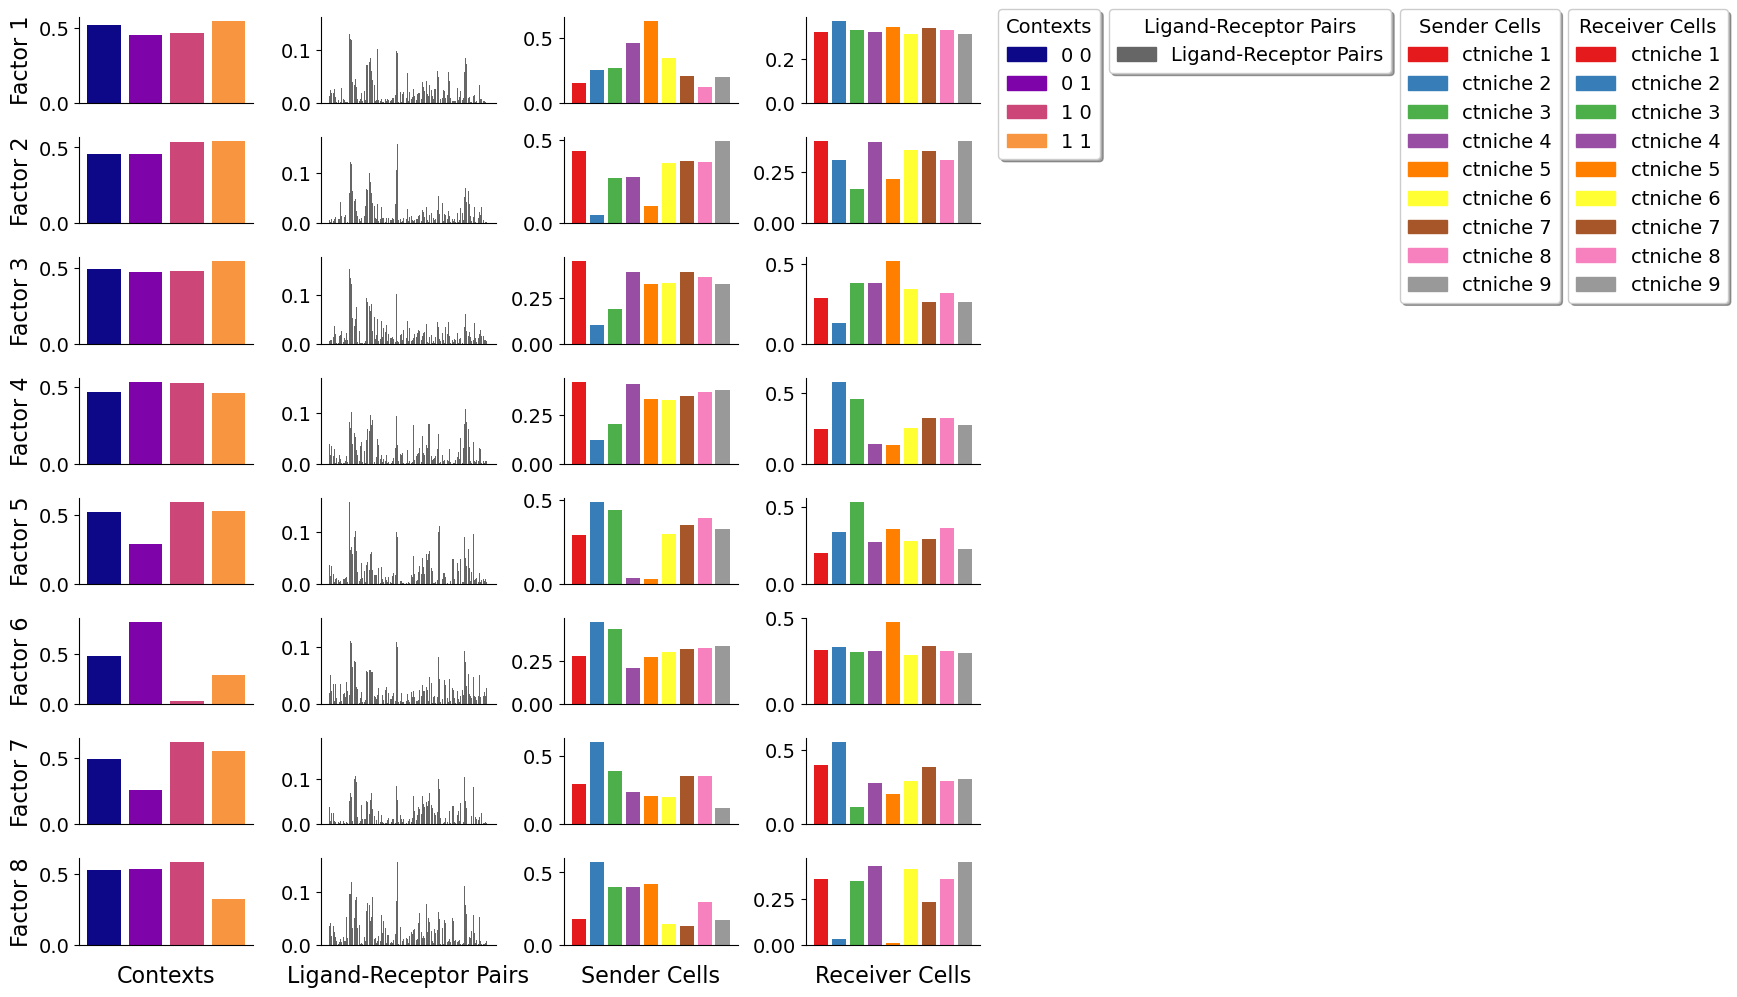

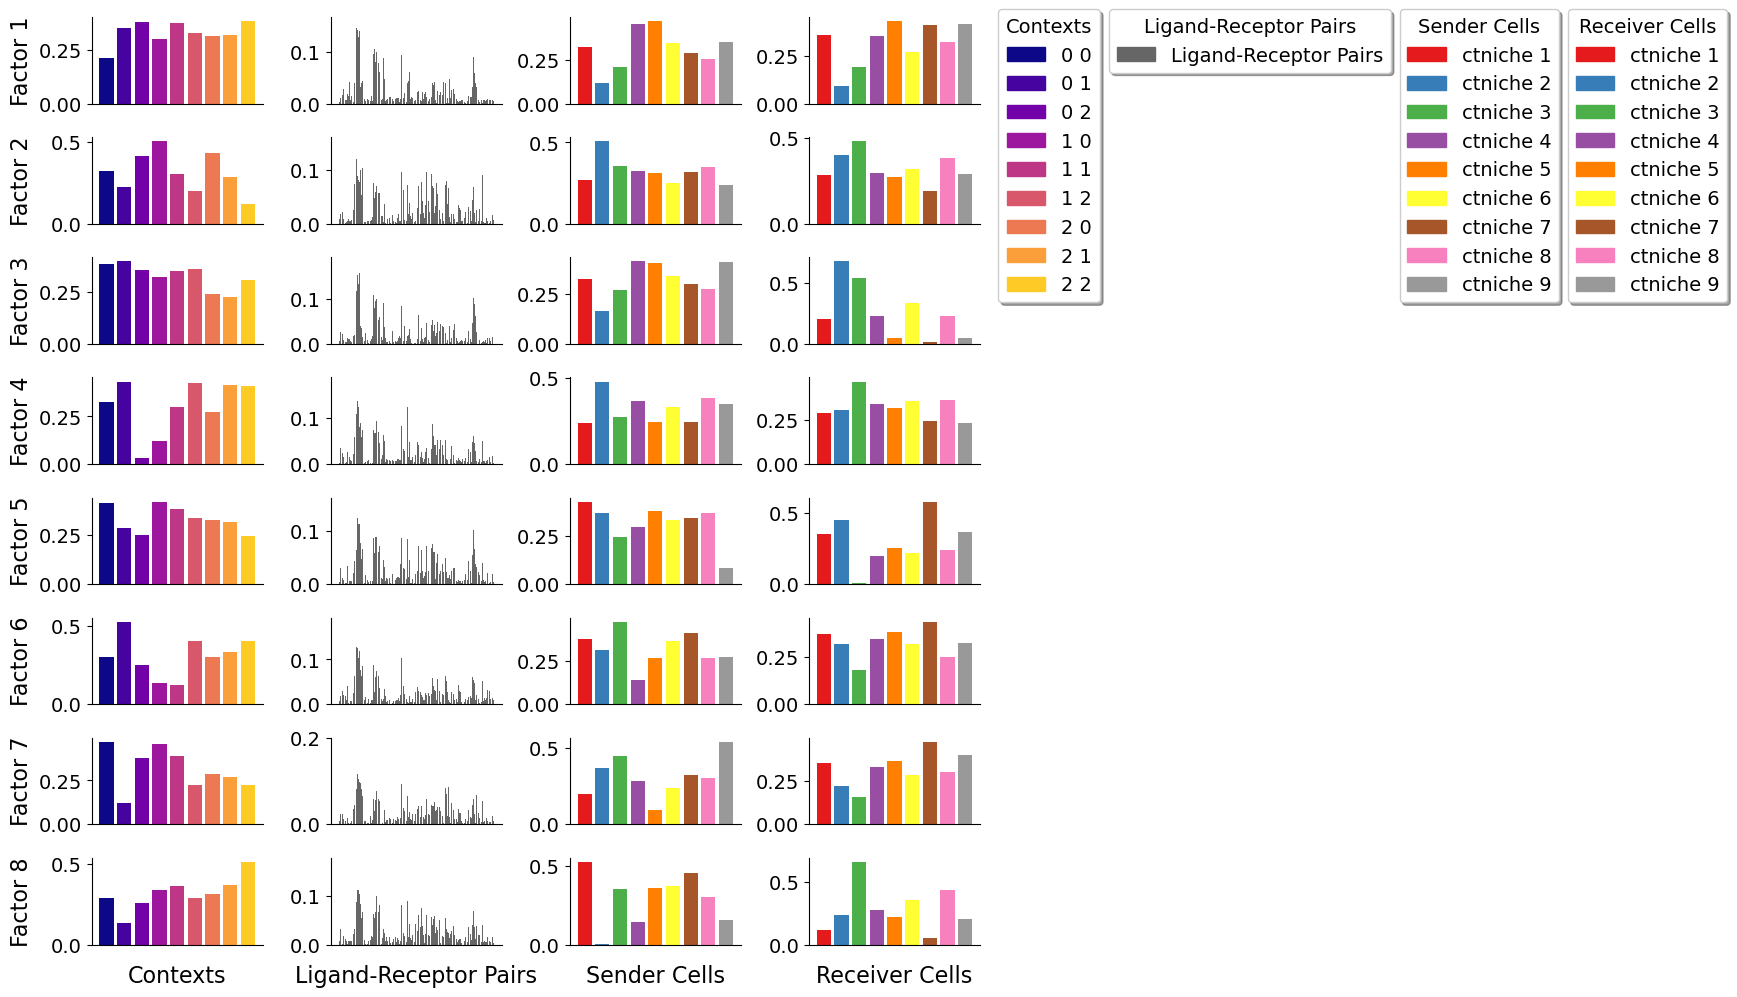

In [32]:
results = run_pipeline_per_bins(adata_og, lr_pairs, cell_group, bin_list=[2,3], output_folder=output_folder)

Let's visualize the imprtant bins per factor for the different grids

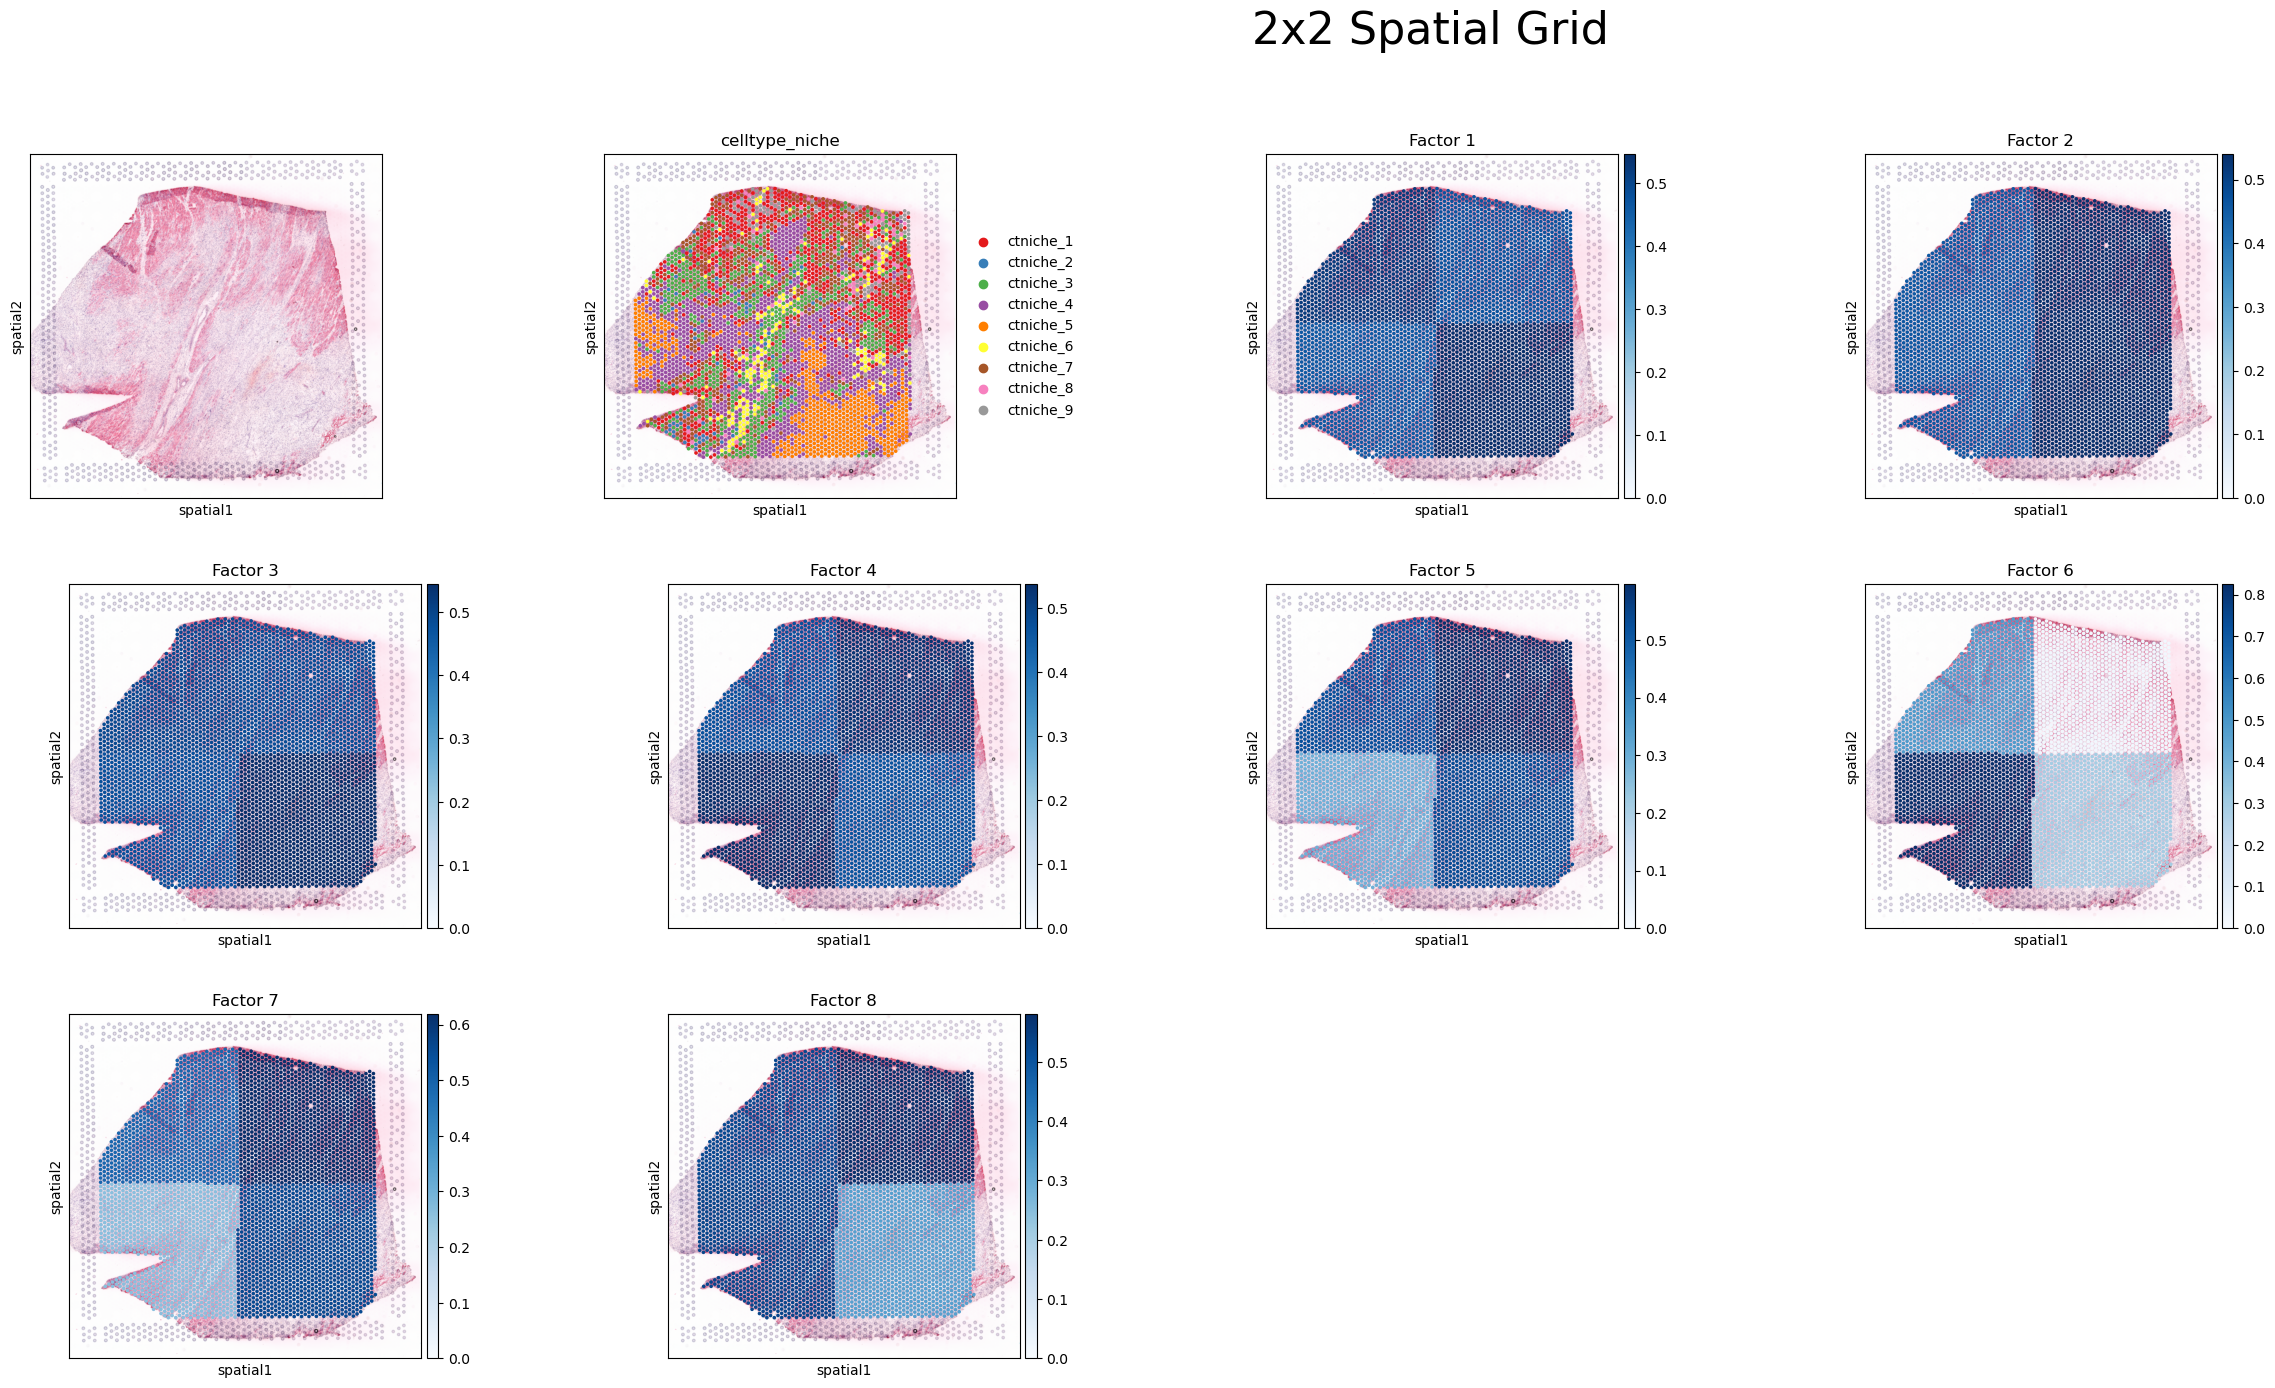

In [ ]:
for k, v in results.items():
    factor_names = list(v['tensor'].factors['Contexts'].columns)
    sq.pl.spatial_scatter(v['adata'], color=[None, 'celltype_niche']+factor_names, size=1.3, cmap='Blues', vmin=0.)
    plt.suptitle(f'{k}x{k} Spatial Grid', fontsize=32, ha='left')

As the size of the grid window increases, it becomes more challenging to discern regional differences within the tissue due to the coarser resolution provided by these larger windows. In this case, more cell-cell interactions are capture per window, making difficult to identify patterns associated with more specific spots. Conversely, smaller grid windows offer a finer resolution, enabling a clearer distinction and more detailed understanding of the variations between different tissue regions.